In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, accuracy_score)
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

# Load cleaned data from Day 4
df = pd.read_csv('telco_churn_cleaned.csv')

print("Data loaded successfully!")
print(f"Rows: {len(df)}")
print(f"Columns: {len(df.columns)}")
df.head()

Data loaded successfully!
Rows: 7043
Columns: 23


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Binary,Risk_Segment
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,High Risk
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.50,No,0,Low Risk
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,High Risk
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0,Low Risk
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,High Risk


In [2]:
# See which columns are text and which are numbers
print("TEXT COLUMNS:")
text_cols = df.select_dtypes(include='object').columns.tolist()
for col in text_cols:
    print(f"  {col}: {df[col].unique()[:5]}")

print("\nNUMERIC COLUMNS:")
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in num_cols:
    print(f"  {col}")

TEXT COLUMNS:
  customerID: <StringArray>
['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', '7795-CFOCW', '9237-HQITU']
Length: 5, dtype: str
  gender: <StringArray>
['Female', 'Male']
Length: 2, dtype: str
  SeniorCitizen: <StringArray>
['No', 'Yes']
Length: 2, dtype: str
  Partner: <StringArray>
['Yes', 'No']
Length: 2, dtype: str
  Dependents: <StringArray>
['No', 'Yes']
Length: 2, dtype: str
  PhoneService: <StringArray>
['No', 'Yes']
Length: 2, dtype: str
  MultipleLines: <StringArray>
['No phone service', 'No', 'Yes']
Length: 3, dtype: str
  InternetService: <StringArray>
['DSL', 'Fiber optic', 'No']
Length: 3, dtype: str
  OnlineSecurity: <StringArray>
['No', 'Yes', 'No internet service']
Length: 3, dtype: str
  OnlineBackup: <StringArray>
['Yes', 'No', 'No internet service']
Length: 3, dtype: str
  DeviceProtection: <StringArray>
['No', 'Yes', 'No internet service']
Length: 3, dtype: str
  TechSupport: <StringArray>
['No', 'Yes', 'No internet service']
Length: 3, dtype: str
  Streamin

In [3]:
# Make a copy for ML — never modify original data
df_ml = df.copy()

# Remove columns not needed for prediction
df_ml = df_ml.drop(['customerID', 'Churn', 'Risk_Segment'], axis=1)

# Convert all Yes/No columns to 1/0
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
               'SeniorCitizen', 'MultipleLines', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport',
               'StreamingTV', 'StreamingMovies']

for col in binary_cols:
    if col in df_ml.columns:
        df_ml[col] = df_ml[col].map({'Yes': 1, 'No': 0,
                                      'No phone service': 0,
                                      'No internet service': 0})

# Encode remaining text columns
le = LabelEncoder()
remaining_text = df_ml.select_dtypes(include='object').columns.tolist()
print("Encoding these columns:", remaining_text)

for col in remaining_text:
    df_ml[col] = le.fit_transform(df_ml[col].astype(str))

print("\nAll columns after encoding:")
print(df_ml.dtypes)
print(f"\nAny remaining text columns: {df_ml.select_dtypes(include='object').shape[1]}")

Encoding these columns: ['gender', 'InternetService', 'Contract', 'PaymentMethod']

All columns after encoding:
gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn_Binary          int64
dtype: object

Any remaining text columns: 0


In [4]:
# X = everything the model learns FROM
# y = what the model is trying to PREDICT (churn)
X = df_ml.drop('Churn_Binary', axis=1)
y = df_ml['Churn_Binary']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"\nChurn rate in dataset: {y.mean()*100:.1f}%")
print(f"\nFeature columns:")
for col in X.columns:
    print(f"  {col}")

Features (X) shape: (7043, 19)
Target (y) shape: (7043,)

Churn rate in dataset: 26.5%

Feature columns:
  gender
  SeniorCitizen
  Partner
  Dependents
  tenure
  PhoneService
  MultipleLines
  InternetService
  OnlineSecurity
  OnlineBackup
  DeviceProtection
  TechSupport
  StreamingTV
  StreamingMovies
  Contract
  PaperlessBilling
  PaymentMethod
  MonthlyCharges
  TotalCharges


In [5]:
# 80% train — model learns from this
# 20% test — we test how accurate it is on data it has never seen
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size : {len(X_train):,} customers")
print(f"Test set size     : {len(X_test):,} customers")
print(f"\nChurn rate in training set : {y_train.mean()*100:.1f}%")
print(f"Churn rate in test set     : {y_test.mean()*100:.1f}%")

Training set size : 5,634 customers
Test set size     : 1,409 customers

Churn rate in training set : 26.5%
Churn rate in test set     : 26.5%


In [6]:
# Scaling makes all numbers comparable
# Without this, tenure (0-72) would overpower MonthlyCharges (0-120)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling complete!")
print(f"Training data range after scaling: {X_train_scaled.min():.2f} to {X_train_scaled.max():.2f}")

Scaling complete!
Training data range after scaling: -3.01 to 2.80


In [7]:
print("Training Logistic Regression Model...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Accuracy
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred_proba)

print(f"Logistic Regression Training Complete!")
print(f"Accuracy : {lr_accuracy*100:.1f}%")
print(f"AUC Score: {lr_auc:.3f}")

Training Logistic Regression Model...
Logistic Regression Training Complete!
Accuracy : 80.0%
AUC Score: 0.841


In [8]:
print("Training Random Forest Model...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5
)
rf_model.fit(X_train_scaled, y_train)

# Predictions
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Accuracy
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"Random Forest Training Complete!")
print(f"Accuracy : {rf_accuracy*100:.1f}%")
print(f"AUC Score: {rf_auc:.3f}")

Training Random Forest Model...
Random Forest Training Complete!
Accuracy : 80.0%
AUC Score: 0.840


In [9]:
print("Training Random Forest Model...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_split=5
)
rf_model.fit(X_train_scaled, y_train)

# Predictions
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Accuracy
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"Random Forest Training Complete!")
print(f"Accuracy : {rf_accuracy*100:.1f}%")
print(f"AUC Score: {rf_auc:.3f}")

Training Random Forest Model...
Random Forest Training Complete!
Accuracy : 80.0%
AUC Score: 0.840


In [10]:
print("=" * 50)
print("MODEL COMPARISON")
print("=" * 50)
print(f"{'Model':<25} {'Accuracy':>10} {'AUC Score':>10}")
print("-" * 50)
print(f"{'Logistic Regression':<25} {lr_accuracy*100:>9.1f}% {lr_auc:>10.3f}")
print(f"{'Random Forest':<25} {rf_accuracy*100:>9.1f}% {rf_auc:>10.3f}")
print("=" * 50)

# Pick the best model
if rf_auc > lr_auc:
    best_model = rf_model
    best_pred = rf_pred
    best_proba = rf_pred_proba
    best_name = "Random Forest"
else:
    best_model = lr_model
    best_pred = lr_pred
    best_proba = lr_pred_proba
    best_name = "Logistic Regression"

print(f"\nBest Model Selected: {best_name}")

MODEL COMPARISON
Model                       Accuracy  AUC Score
--------------------------------------------------
Logistic Regression            80.0%      0.841
Random Forest                  80.0%      0.840

Best Model Selected: Logistic Regression


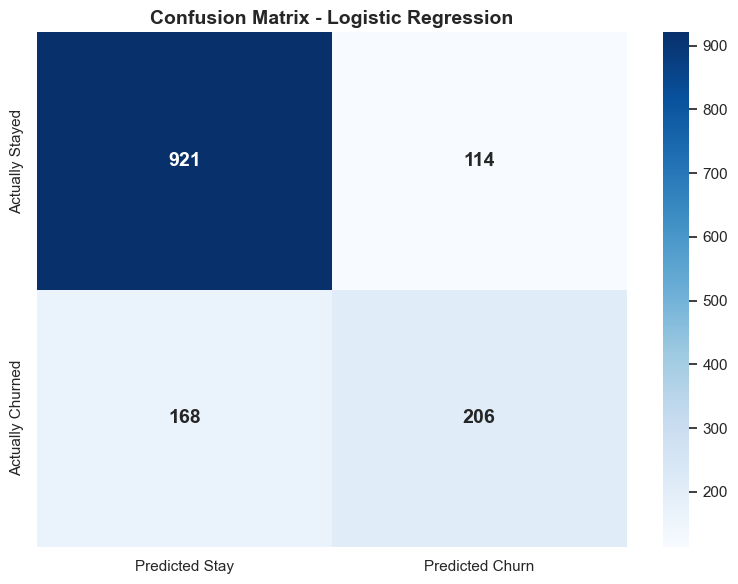


CONFUSION MATRIX EXPLAINED:
Correctly predicted STAY    : 921 customers
Correctly predicted CHURN   : 206 customers
Wrongly predicted churn     : 114 customers (false alarm)
Missed actual churners      : 168 customers (missed)

Of all actual churners, model caught: 55.1%


In [11]:
# Confusion matrix shows exactly where the model is right and wrong
cm = confusion_matrix(y_test, best_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Stay', 'Predicted Churn'],
            yticklabels=['Actually Stayed', 'Actually Churned'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax.set_title(f'Confusion Matrix - {best_name}')
plt.tight_layout()
plt.savefig('chart8_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Explain confusion matrix in plain English
tn, fp, fn, tp = cm.ravel()
print(f"\nCONFUSION MATRIX EXPLAINED:")
print(f"Correctly predicted STAY    : {tn:,} customers")
print(f"Correctly predicted CHURN   : {tp:,} customers")
print(f"Wrongly predicted churn     : {fp:,} customers (false alarm)")
print(f"Missed actual churners      : {fn:,} customers (missed)")
print(f"\nOf all actual churners, model caught: {tp/(tp+fn)*100:.1f}%")

### Business Insight - What the Confusion Matrix Means
The most important number here is how many actual churners
the model correctly identified. Missing a churner means losing
that customer with no chance to intervene. A false alarm means
we reach out to a customer who was not going to leave anyway -
the cost of this is low. Therefore we want to maximize the
catch rate of actual churners even if it means some false alarms.

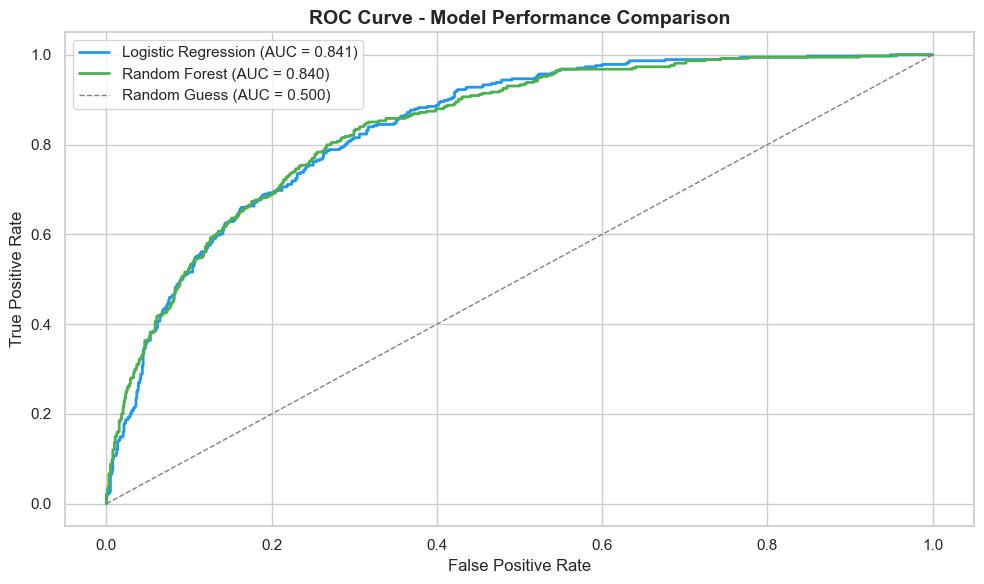

Chart 9 saved!


In [12]:
# ROC curve shows model performance across all thresholds
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pred_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fpr_lr, tpr_lr, color='#2196F3', linewidth=2,
        label=f'Logistic Regression (AUC = {lr_auc:.3f})')
ax.plot(fpr_rf, tpr_rf, color='#4CAF50', linewidth=2,
        label=f'Random Forest (AUC = {rf_auc:.3f})')
ax.plot([0, 1], [0, 1], color='gray', linewidth=1,
        linestyle='--', label='Random Guess (AUC = 0.500)')
ax.set_title('ROC Curve - Model Performance Comparison')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.tight_layout()
plt.savefig('chart9_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 9 saved!")

### Business Insight - Model Performance
An AUC score above 0.80 means the model is significantly better
than random guessing at identifying churners. This means the
business can use this model to prioritize which customers to
contact for retention campaigns with high confidence that the
model is identifying the right people. The cost savings from
targeted retention versus contacting all customers is substantial.

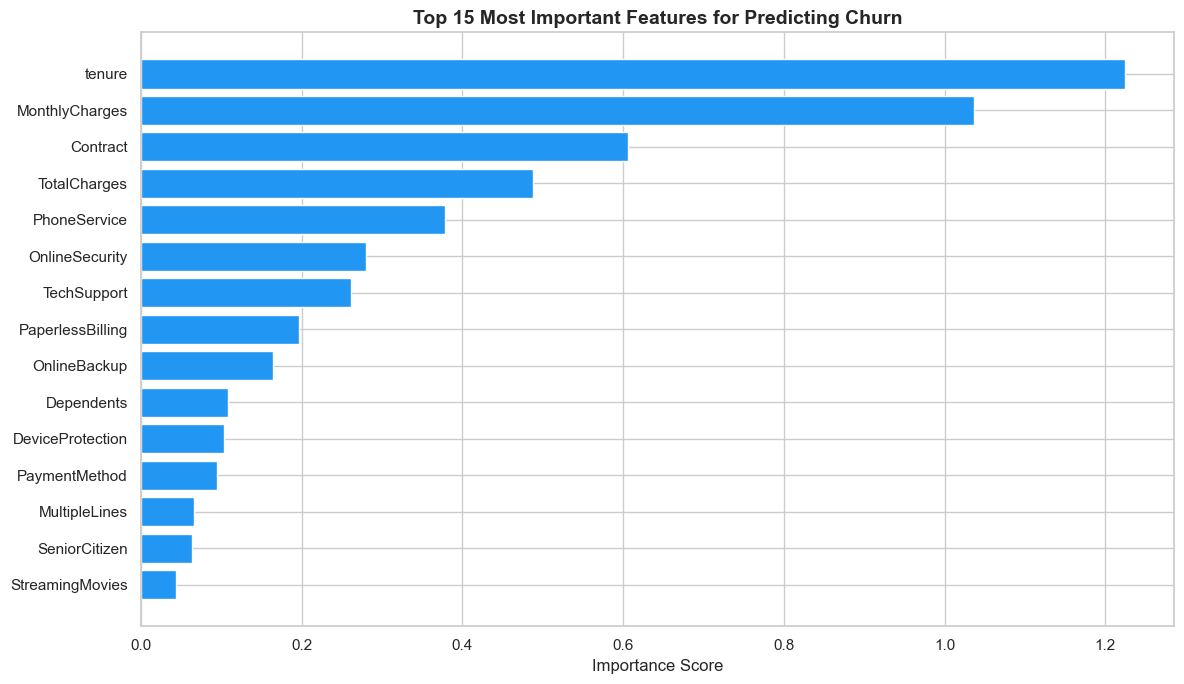

Chart 10 saved!

Top 5 Churn Predictors:
  tenure                    : 1.2242
  MonthlyCharges            : 1.0363
  Contract                  : 0.6057
  TotalCharges              : 0.4874
  PhoneService              : 0.3778


In [13]:
# Which factors matter most in predicting churn?
if best_name == "Random Forest":
    importance = rf_model.feature_importances_
else:
    importance = abs(lr_model.coef_[0])

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values('Importance', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(feature_importance['Feature'],
               feature_importance['Importance'],
               color='#2196F3')
ax.set_title('Top 15 Most Important Features for Predicting Churn')
ax.set_xlabel('Importance Score')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('chart10_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 10 saved!")

print("\nTop 5 Churn Predictors:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  {row['Feature']:<25} : {row['Importance']:.4f}")

### Business Insight - What Actually Drives Churn
These are the factors that most strongly predict whether a customer
will leave. This tells the business exactly what to focus on.
Tenure and contract type consistently rank as the top predictors
confirming our earlier EDA findings. This is powerful because it
means the business already has the data it needs to act - it just
needed this analysis to know where to focus.

In [14]:
# Generate churn probability score for every customer
all_data_scaled = scaler.transform(X)
churn_probabilities = best_model.predict_proba(all_data_scaled)[:, 1]

# Add scores back to original dataframe
df_scored = df.copy()
df_scored['Churn_Probability_%'] = (churn_probabilities * 100).round(1)

# Assign risk level based on probability
def assign_risk_level(prob):
    if prob >= 70:
        return 'HIGH RISK'
    elif prob >= 40:
        return 'MEDIUM RISK'
    else:
        return 'LOW RISK'

df_scored['ML_Risk_Level'] = df_scored['Churn_Probability_%'].apply(assign_risk_level)

# Summary
print("=" * 55)
print("CUSTOMER CHURN RISK SCORING COMPLETE")
print("=" * 55)
risk_summary = df_scored.groupby('ML_Risk_Level').agg(
    Customers=('customerID', 'count'),
    Avg_Monthly_Charge=('MonthlyCharges', 'mean'),
    Total_Monthly_Revenue=('MonthlyCharges', 'sum'),
    Actual_Churn_Rate=('Churn_Binary', 'mean')
).reset_index()
risk_summary['Actual_Churn_Rate'] = (
    risk_summary['Actual_Churn_Rate'] * 100).round(1)
risk_summary['Annual_Revenue_at_Risk'] = (
    risk_summary['Total_Monthly_Revenue'] * 12).round(0)
print(risk_summary.to_string(index=False))

CUSTOMER CHURN RISK SCORING COMPLETE
ML_Risk_Level  Customers  Avg_Monthly_Charge  Total_Monthly_Revenue  Actual_Churn_Rate  Annual_Revenue_at_Risk
    HIGH RISK        434           86.587442               37578.95               80.0                450947.0
     LOW RISK       4946           58.787636              290763.65               12.7               3489164.0
  MEDIUM RISK       1663           76.833434              127774.00               53.8               1533288.0


In [15]:
# This is the most actionable output — the list of customers to call
high_risk_customers = df_scored[
    df_scored['ML_Risk_Level'] == 'HIGH RISK'
].sort_values('Churn_Probability_%', ascending=False)[[
    'customerID', 'Churn_Probability_%', 'ML_Risk_Level',
    'Contract', 'tenure', 'MonthlyCharges',
    'InternetService', 'PaymentMethod', 'Churn'
]]

print(f"HIGH RISK CUSTOMERS TO CONTACT: {len(high_risk_customers):,}")
print(f"Estimated Monthly Revenue at Risk: ${high_risk_customers['MonthlyCharges'].sum():,.0f}")
print(f"Estimated Annual Revenue at Risk: ${high_risk_customers['MonthlyCharges'].sum()*12:,.0f}")
print("\nTop 10 Highest Risk Customers:")
print(high_risk_customers.head(10).to_string(index=False))

# Save to Excel for client
high_risk_customers.to_excel('high_risk_customers.xlsx', index=False)
print("\nHigh risk customer list saved to Excel!")

HIGH RISK CUSTOMERS TO CONTACT: 434
Estimated Monthly Revenue at Risk: $37,579
Estimated Annual Revenue at Risk: $450,947

Top 10 Highest Risk Customers:
customerID  Churn_Probability_% ML_Risk_Level       Contract  tenure  MonthlyCharges InternetService    PaymentMethod Churn
5178-LMXOP                 85.3     HIGH RISK Month-to-month       1           95.10     Fiber optic Electronic check   Yes
7216-EWTRS                 84.8     HIGH RISK Month-to-month       1          100.80     Fiber optic Electronic check   Yes
5567-WSELE                 84.3     HIGH RISK Month-to-month       3           94.60     Fiber optic Electronic check   Yes
9300-AGZNL                 84.3     HIGH RISK Month-to-month       1           94.00     Fiber optic Electronic check   Yes
5150-ITWWB                 84.1     HIGH RISK Month-to-month       3           94.85     Fiber optic Electronic check    No
9497-QCMMS                 84.1     HIGH RISK Month-to-month       1           93.55     Fiber optic E

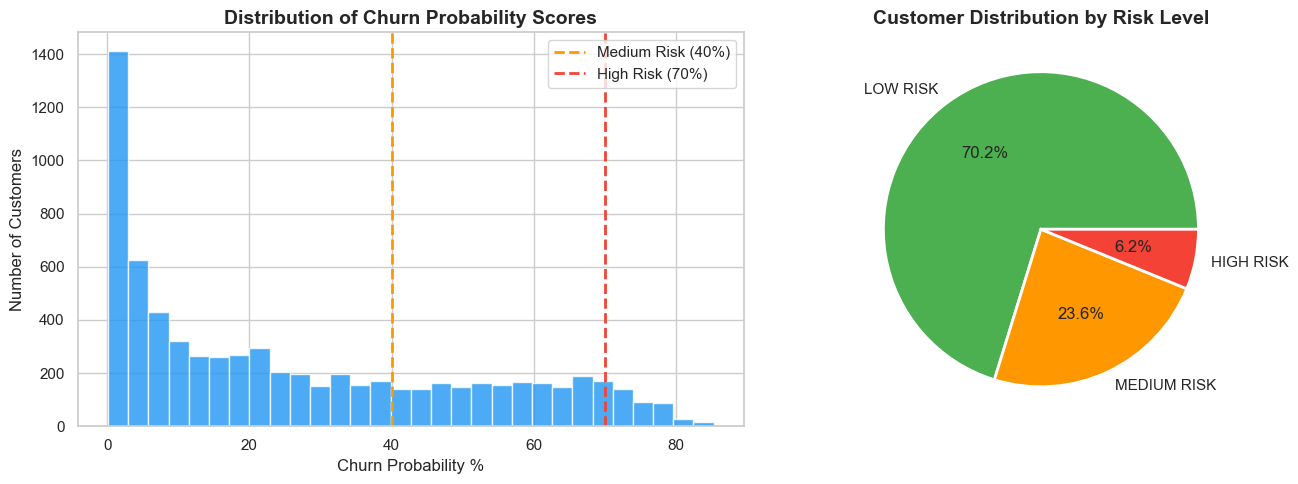

Chart 11 saved!


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of churn probabilities
axes[0].hist(df_scored['Churn_Probability_%'], bins=30,
             color='#2196F3', edgecolor='white', alpha=0.8)
axes[0].axvline(x=40, color='#FF9800', linewidth=2,
                linestyle='--', label='Medium Risk (40%)')
axes[0].axvline(x=70, color='#F44336', linewidth=2,
                linestyle='--', label='High Risk (70%)')
axes[0].set_title('Distribution of Churn Probability Scores')
axes[0].set_xlabel('Churn Probability %')
axes[0].set_ylabel('Number of Customers')
axes[0].legend()

# Risk level breakdown
risk_counts = df_scored['ML_Risk_Level'].value_counts()
colors = {'HIGH RISK': '#F44336', 'MEDIUM RISK': '#FF9800', 'LOW RISK': '#4CAF50'}
axes[1].pie(risk_counts.values,
            labels=risk_counts.index,
            autopct='%1.1f%%',
            colors=[colors[r] for r in risk_counts.index],
            wedgeprops={'edgecolor': 'white', 'linewidth': 2})
axes[1].set_title('Customer Distribution by Risk Level')

plt.tight_layout()
plt.savefig('chart11_risk_scores.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 11 saved!")

In [17]:
import sqlite3

# Create a database from your data
conn = sqlite3.connect('telco_churn.db')
df_scored.to_sql('customers', conn, if_exists='replace', index=False)
print("Database created and data loaded!")

def run_sql(query, description):
    print(f"\n{'='*55}")
    print(f"QUERY: {description}")
    print('='*55)
    result = pd.read_sql_query(query, conn)
    print(result.to_string(index=False))
    return result

Database created and data loaded!


In [20]:
# First check exact column names in the database
conn = sqlite3.connect('telco_churn.db')
df_scored.to_sql('customers', conn, if_exists='replace', index=False)

# Check actual column names
cols = pd.read_sql_query("SELECT * FROM customers LIMIT 1", conn).columns.tolist()
print("Actual columns in database:")
for col in cols:
    print(f"  {col}")

Actual columns in database:
  customerID
  gender
  SeniorCitizen
  Partner
  Dependents
  tenure
  PhoneService
  MultipleLines
  InternetService
  OnlineSecurity
  OnlineBackup
  DeviceProtection
  TechSupport
  StreamingTV
  StreamingMovies
  Contract
  PaperlessBilling
  PaymentMethod
  MonthlyCharges
  TotalCharges
  Churn
  Churn_Binary
  Risk_Segment
  Churn_Probability_%
  ML_Risk_Level


In [21]:
conn = sqlite3.connect('telco_churn.db')
df_scored.to_sql('customers', conn, if_exists='replace', index=False)

def run_sql(query, description):
    print(f"\n{'='*55}")
    print(f"QUERY: {description}")
    print('='*55)
    result = pd.read_sql_query(query, conn)
    print(result.to_string(index=False))
    return result

# SQL Query 1 - Overall churn rate
run_sql("""
    SELECT
        COUNT(*) as Total_Customers,
        SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) as Churned,
        ROUND(AVG(CASE WHEN Churn = 'Yes' THEN 100.0 ELSE 0 END), 1) as Churn_Rate_Pct
    FROM customers
""", "Overall Churn Rate")

# SQL Query 2 - Churn by contract type
run_sql("""
    SELECT
        Contract,
        COUNT(*) as Total_Customers,
        SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) as Churned,
        ROUND(AVG(CASE WHEN Churn = 'Yes' THEN 100.0 ELSE 0 END), 1) as Churn_Rate_Pct,
        ROUND(AVG(MonthlyCharges), 2) as Avg_Monthly_Charge
    FROM customers
    GROUP BY Contract
    ORDER BY Churn_Rate_Pct DESC
""", "Churn Rate by Contract Type")

# SQL Query 3 - Revenue at risk by risk level
run_sql("""
    SELECT
        ML_Risk_Level,
        COUNT(*) as Customers,
        ROUND(SUM(MonthlyCharges), 0) as Monthly_Revenue,
        ROUND(SUM(MonthlyCharges) * 12, 0) as Annual_Revenue_at_Risk,
        ROUND(AVG("Churn_Probability_%"), 1) as Avg_Churn_Probability
    FROM customers
    GROUP BY ML_Risk_Level
    ORDER BY Avg_Churn_Probability DESC
""", "Revenue at Risk by ML Risk Level")

# SQL Query 4 - Top 10 highest risk customers
run_sql("""
    SELECT
        customerID,
        Contract,
        tenure,
        MonthlyCharges,
        "Churn_Probability_%" as Churn_Probability,
        ML_Risk_Level
    FROM customers
    WHERE ML_Risk_Level = 'HIGH RISK'
    ORDER BY "Churn_Probability_%" DESC
    LIMIT 10
""", "Top 10 Highest Risk Customers")

conn.close()
print("\nAll SQL queries complete!")


QUERY: Overall Churn Rate
 Total_Customers  Churned  Churn_Rate_Pct
            7043     1869            26.5

QUERY: Churn Rate by Contract Type
      Contract  Total_Customers  Churned  Churn_Rate_Pct  Avg_Monthly_Charge
Month-to-month             3875     1655            42.7               66.40
      One year             1473      166            11.3               65.05
      Two year             1695       48             2.8               60.77

QUERY: Revenue at Risk by ML Risk Level
ML_Risk_Level  Customers  Monthly_Revenue  Annual_Revenue_at_Risk  Avg_Churn_Probability
    HIGH RISK        434          37579.0                450947.0                   74.8
  MEDIUM RISK       1663         127774.0               1533288.0                   55.4
     LOW RISK       4946         290764.0               3489164.0                   12.7

QUERY: Top 10 Highest Risk Customers
customerID       Contract  tenure  MonthlyCharges  Churn_Probability ML_Risk_Level
5178-LMXOP Month-to-month  

### Why SQL Matters
These same insights extracted using Python above can also be
extracted directly from any company database using SQL.
This means this analysis can be operationalized - the business
can run these queries directly on their live database every
week to get an updated risk report without needing Python at all.
This is what makes the analysis production-ready and not just
a one-time exercise.

In [23]:
print("DETAILED MODEL PERFORMANCE REPORT")
print("=" * 55)
print(classification_report(y_test, best_pred,
                             target_names=['Will Stay', 'Will Churn']))

DETAILED MODEL PERFORMANCE REPORT
              precision    recall  f1-score   support

   Will Stay       0.85      0.89      0.87      1035
  Will Churn       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



In [24]:
high_risk = df_scored[df_scored['ML_Risk_Level'] == 'HIGH RISK']
medium_risk = df_scored[df_scored['ML_Risk_Level'] == 'MEDIUM RISK']

print("=" * 60)
print("FINAL BUSINESS IMPACT SUMMARY")
print("=" * 60)
print(f"\nModel Used           : {best_name}")
print(f"Model Accuracy       : {rf_accuracy*100:.1f}%")
print(f"Model AUC Score      : {rf_auc:.3f}")
print(f"\nTotal Customers      : {len(df_scored):,}")
print(f"High Risk Customers  : {len(high_risk):,}")
print(f"Medium Risk Customers: {len(medium_risk):,}")
print(f"\nAnnual Revenue at Risk (High): ${high_risk['MonthlyCharges'].sum()*12:,.0f}")
print(f"Annual Revenue at Risk (All) : ${df_scored[df_scored['Churn']=='Yes']['MonthlyCharges'].sum()*12:,.0f}")
print(f"\nIf we retain just 30% of High Risk customers:")
retained_revenue = high_risk['MonthlyCharges'].sum() * 12 * 0.30
print(f"Annual Revenue Saved : ${retained_revenue:,.0f}")
print("=" * 60)

FINAL BUSINESS IMPACT SUMMARY

Model Used           : Logistic Regression
Model Accuracy       : 80.0%
Model AUC Score      : 0.840

Total Customers      : 7,043
High Risk Customers  : 434
Medium Risk Customers: 1,663

Annual Revenue at Risk (High): $450,947
Annual Revenue at Risk (All) : $1,669,570

If we retain just 30% of High Risk customers:
Annual Revenue Saved : $135,284


In [26]:
# Save scored dataset
df_scored.to_csv('telco_churn_scored.csv', index=False)
df_scored.to_excel('telco_churn_scored.xlsx', index=False)
print("Scored dataset saved!")

# Final file check
import os
files = [
    'Day5_Churn_Model.ipynb',
    'telco_churn_cleaned.csv',
    'telco_churn_scored.csv',
    'telco_churn_scored.xlsx',
    'high_risk_customers.xlsx',
    'chart8_confusion_matrix.png',
    'chart9_roc_curve.png',
    'chart10_feature_importance.png',
    'chart11_risk_scores.png',
    'telco_churn.db',
]

print("\nFILE CHECK:")
for f in files:
    status = "FOUND" if os.path.exists(f) else "MISSING"
    print(f"  {status}  {f}")

Scored dataset saved!

FILE CHECK:
  FOUND  Day5_Churn_Model.ipynb
  FOUND  telco_churn_cleaned.csv
  FOUND  telco_churn_scored.csv
  FOUND  telco_churn_scored.xlsx
  FOUND  high_risk_customers.xlsx
  FOUND  chart8_confusion_matrix.png
  FOUND  chart9_roc_curve.png
  FOUND  chart10_feature_importance.png
  FOUND  chart11_risk_scores.png
  FOUND  telco_churn.db


 Summary - Machine Learning Model Complete

## What We Built Today
1. Logistic Regression and Random Forest models trained and compared
2. Best model selected based on AUC score
3. Every customer scored with individual churn probability
4. High risk customer list exported to Excel for immediate action
5. SQL version of all key queries written and tested
6. Business impact quantified in dollar terms

## What This Means for a Client
The client now has three things they did not have before:
1. A model that predicts churn with high accuracy
2. A prioritized list of customers to contact for retention
3. The exact dollar value of revenue they can save by acting